<a href="https://colab.research.google.com/github/nando-cezar/mcer/blob/main/mcer_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import userdata

import requests_cache
from retry_requests import retry

import seaborn as sns
import matplotlib.pyplot as plt

import openmeteo_requests

#OPEN-METEO - Historical Weather API


> Load weather information from API

## API call

> Algorithm for processing data (Search weather from latitude and longitude)


In [14]:
# Setup the Open-Meteo API client with cache and retry on error
# Cache session to store API responses locally
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
# Retry session to automatically retry requests in case of errors
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
# Create Open-Meteo API client with the retry session
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to search for weather information using Open-Meteo API
def search_info_weather(latitude, longitude, start_date, end_date, timezone):

    # Define parameters for API request
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "apparent_temperature_mean",
            "sunrise",
            "sunset",
            "daylight_duration",
            "sunshine_duration",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
            ],
        "timezone": timezone,
    }

    # Call Open-Meteo API to retrieve weather data
    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo_historical'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily weather data
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(19)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "apparent_temperature_mean",
        "sunrise",
        "sunset",
        "daylight_duration",
        "sunshine_duration",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]

    # Create dictionary to store daily weather data
    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}

    # Populate daily data dictionary with weather information
    #daily_data["latitude"] = response.Latitude()
    #daily_data["longitude"] = response.Longitude()
    #daily_data["start_date"] = start_date
    #daily_data["end_date"] = end_date

    # Add weather variables to daily data dictionary
    for name, values in zip(variable_names, variables):
        daily_data[name] = values

    return daily_data

> Getting information and formatting dataframe

In [15]:
_info = search_info_weather(
    latitude=52.52,               # Latitude
    longitude=13.41,              # Longitude
    start_date="2010-10-09",      # Start date
    end_date="2024-10-23",        # End date
    timezone="America/Sao_Paulo",         # Timezone
)

##Data visualization without processing

In [16]:
df = pd.DataFrame(data = _info)
display(df)

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2010-10-09 03:00:00,13.789000,5.1390,9.484833,10.372216,1.714530,6.006411,0,0,39831.714844,32361.269531,0.0,0.0,0.0,0.0,17.339897,36.000000,95.585892,9.92,1.762527
1,2010-10-10 03:00:00,13.438999,1.9390,7.220250,10.346421,-0.944233,4.288283,0,0,39590.945312,35359.574219,0.0,0.0,0.0,0.0,12.768586,29.160000,67.210808,11.54,1.532416
2,2010-10-11 03:00:00,10.039000,1.4890,6.943166,7.524269,-1.277557,4.749788,0,0,39351.511719,20164.626953,0.0,0.0,0.0,0.0,10.948973,24.480000,44.486950,7.28,0.868499
3,2010-10-12 03:00:00,10.639000,6.3390,8.295249,9.241452,4.572071,6.768183,0,0,39113.582031,28449.816406,0.0,0.0,0.0,0.0,5.091168,11.879999,40.640488,6.74,0.922572
4,2010-10-13 03:00:00,10.289000,2.7890,6.159833,8.397052,-0.084918,4.024075,0,0,38876.792969,24939.517578,0.0,0.0,0.0,0.0,8.287822,15.840000,110.758415,6.87,0.866353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5124,2024-10-19 03:00:00,18.658501,10.1085,13.896001,17.697229,7.554279,12.329858,0,0,37300.230469,26225.646484,0.0,0.0,0.0,0.0,19.300331,36.000000,166.641006,7.41,1.339749
5125,2024-10-20 03:00:00,16.608500,10.7085,13.523086,14.767090,9.372928,11.817242,0,0,37066.847656,23983.425781,0.0,0.0,0.0,0.0,16.108742,27.000000,165.354233,7.07,1.310660
5126,2024-10-21 03:00:00,18.808500,13.3585,15.412669,18.716511,12.218222,14.961689,0,0,36833.035156,11818.863281,3.1,3.1,0.0,7.0,17.149191,29.879999,201.567734,4.05,0.878631
5127,2024-10-22 03:00:00,18.008501,7.9085,12.050168,15.065334,5.819112,9.848379,0,0,36598.976562,22763.900391,0.0,0.0,0.0,0.0,27.074896,50.039997,257.986053,5.14,1.028484


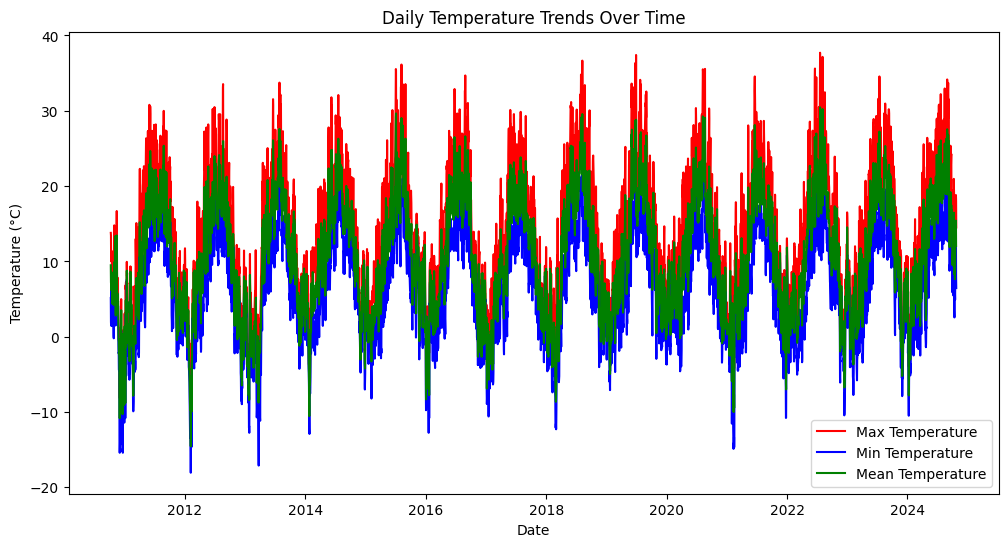

In [17]:
# @title Daily Temperature Trends Over Time

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['temperature_2m_max'], label='Max Temperature', color='red')
plt.plot(df['date'], df['temperature_2m_min'], label='Min Temperature', color='blue')
plt.plot(df['date'], df['temperature_2m_mean'], label='Mean Temperature', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature Trends Over Time')
_ = plt.legend()
